## Loading up packages

In [283]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [322]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from plastid.plotting.plots import *
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
from magic_functions import process_frame
import copy
import seaborn as sns

In [323]:
# Define the path to our data files and the path we want to save our outputs in. 
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/'
ks_ecol_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/ecol/'
ks_dmel_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/dmel/'
samp_num = '2'

## Calculate the KS stat of all of the genes with polyproline motifs in the E.coli data

In [324]:
# Load up the target gene names. 
PPP_table = pd.read_csv(target_path + 'polyproline_motifs.csv')

# Load up the tables of KS statistics
df_ecol = pd.read_csv(ks_ecol_path + "ks_table_" + samp_num + ".csv")

In [325]:
# Correct the column headings and rows for the polyproline table. 
PPP_table.columns = PPP_table.iloc[2]
PPP_table = PPP_table.drop([0,1,2])

# Remove the many unecessary columns from the polyproline data
PPP_table = pd.DataFrame(PPP_table.Gene.unique(), columns = ["Gene"])

# Merge the ecoli ks table with the list of gene names
PPP_ks_table = pd.merge(df_ecol, PPP_table, how='inner', right_on='Gene', left_on='gene_ID')

In [326]:
PPP_ks_table.sort_values("Gene", inplace = True)

In [327]:
PPP_ks_table.drop_duplicates(subset ="Gene",keep = "first", inplace = True) 

(0.0, 0.7)

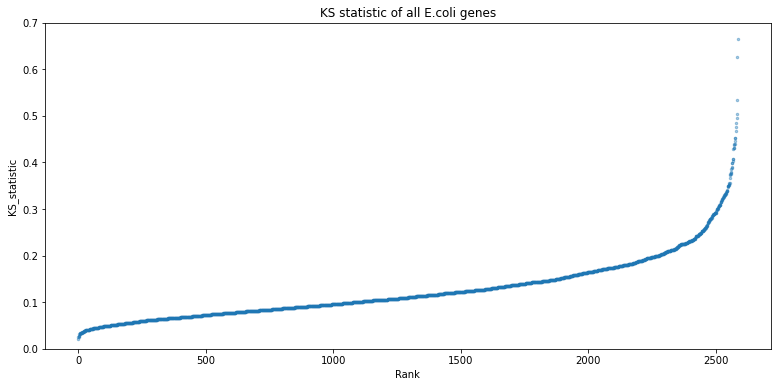

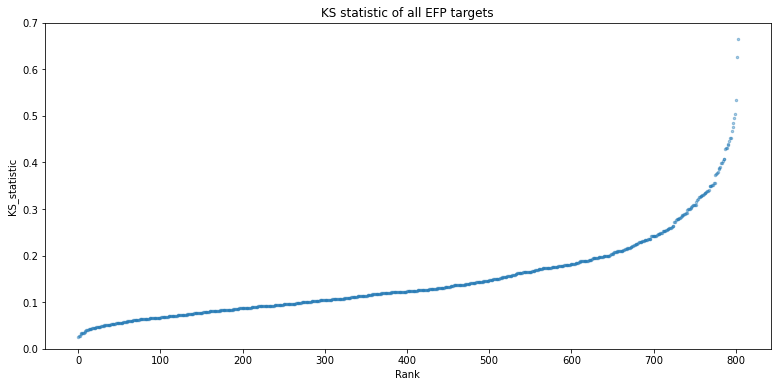

In [328]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (13,6))
plt.scatter(list(range(len(df_ecol["ks_stat"]))), sorted(df_ecol["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all E.coli genes")
plt.ylim(0,0.7)
plt.show
figure(figsize = (13,6))
plt.scatter(list(range(len(PPP_ks_table["ks_stat"]))), sorted(PPP_ks_table["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all EFP targets")
plt.ylim(0,0.7)

In [329]:
np.mean(PPP_ks_table.ks_stat)

0.14819244300190054

In [330]:
np.mean(df_ecol.ks_stat)

0.1270950391250806

In [331]:
## Seeing what fraction of genes with the highest KS stat are polyproline motifs
len(PPP_ks_table.ks_stat[PPP_ks_table.ks_stat > 0.4])

19

In [332]:
len(df_ecol.ks_stat[df_ecol.ks_stat > 0.4])

20

In [333]:
# Expected ratio without enrichment
print(len(PPP_ks_table.ks_stat)/len(df_ecol.ks_stat))

# Observed ratio
print(len(PPP_ks_table.ks_stat[PPP_ks_table.ks_stat > 0.4])/len(df_ecol.ks_stat[df_ecol.ks_stat > 0.4]))

0.3105181747873163
0.95


## Calculate the KS stat of all of the Fmr1 targets in the fly data

In [334]:
# Load up the target gene names. 
Fmr1_table = pd.read_csv(target_path + 'Fmr1_dmel_downreg_genes.txt', names = ["gene_name"])

# Load up the tables of KS statistics
df_dmel = pd.read_csv(ks_dmel_path + "ks_table_" + samp_num + ".csv")

In [335]:
# Merge the ecoli ks table with the list of gene names
Fmr1_ks_table = pd.merge(df_dmel, Fmr1_table, how='inner', right_on='gene_name', left_on='gene_ID')

In [336]:
Fmr1_ks_table.sort_values("gene_name", inplace = True)

In [337]:
Fmr1_ks_table.drop_duplicates(subset ="gene_name",keep = "first", inplace = True) 

(0.0, 0.7)

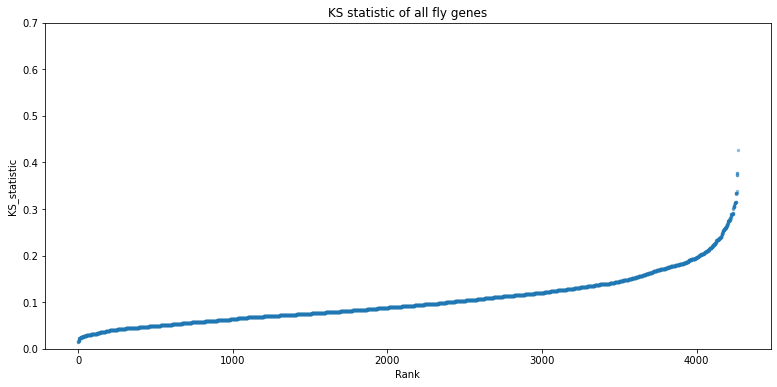

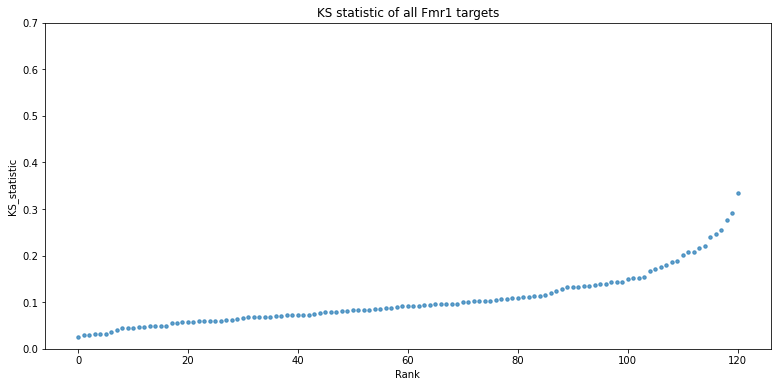

In [338]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (13,6))
plt.scatter(list(range(len(df_dmel["ks_stat"]))), sorted(df_dmel["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all fly genes")
plt.ylim(0,0.7)
plt.show
figure(figsize = (13,6))
plt.scatter(list(range(len(Fmr1_ks_table["ks_stat"]))), sorted(Fmr1_ks_table["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all Fmr1 targets")
plt.ylim(0,0.7)

In [339]:
np.mean(Fmr1_ks_table.ks_stat)

0.10477411920483684

In [340]:
np.mean(df_dmel.ks_stat)

0.10361398282816273

In [341]:
# Expected ratio without enrichment
print(len(Fmr1_ks_table.ks_stat)/len(df_dmel.ks_stat))

# Observed ratio
print(len(Fmr1_ks_table.ks_stat[Fmr1_ks_table.ks_stat > 0.3])/len(df_dmel.ks_stat[df_dmel.ks_stat > 0.3]))

0.028370457209847596
0.034482758620689655


## Looking at the kernel density estimates

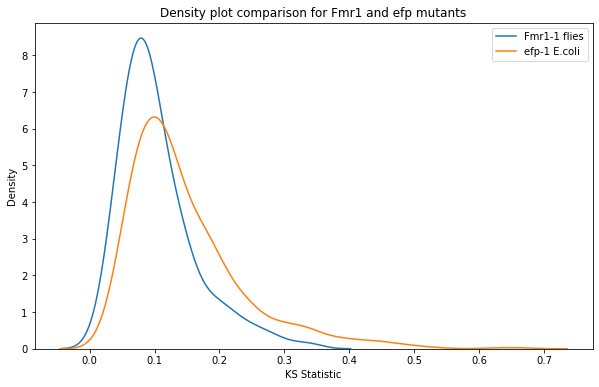

In [342]:
figure(figsize = (10,6))
sns.kdeplot(Fmr1_ks_table.ks_stat, label = "Fmr1-1 flies")
sns.kdeplot(PPP_ks_table.ks_stat, label = "efp-1 E.coli")
plt.ylabel("Density")
plt.xlabel("KS Statistic")
plt.title("Density plot comparison for Fmr1 and efp mutants")
plt.legend()

In [343]:
# Is one way ANOVA what he meant by mean square test?
stats.f_oneway(Fmr1_ks_table.ks_stat, PPP_ks_table.ks_stat)

F_onewayResult(statistic=26.44566601682701, pvalue=3.310741190868279e-07)